## Предсказание победителя в online игре

В работе используется задача предсказания победителя в онлайн-игре DOTA 2 https://inclass.kaggle.com/c/dota-2-win-probability-prediction. Согласно инструкциям курса необходимо построить модели Gradient Boosting и Logistic Regression на исходных признаках, а так же с добавлением мешка героев.

Полученные оценки на kaggle:
1. Градиентный бустинг на исходных признаках с параметрами n_estimators=750, learning_rate=0.1, max_depth=3 дает точность 0.73150 (место 736 из 813), что лучше, чем benchmark для градиентного бустинига, равный 0.72111.

2. Логистическая регрессия на исходных признаках с "мешком героев" дает результат 0.75489 (место 624 из 813)

## Подключение библиотек и импорт данных

In [27]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame
import re
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

pd.options.display.max_rows = 30

data = pd.read_csv('./data/features.csv', index_col='match_id')
test = pd.read_csv('./data/features_test.csv', index_col='match_id')

## Ознакомление с данными

In [28]:
data.head(5).T

match_id,0,1,2,3,4
start_time,1.430199e+09,1.430220e+09,1.430227e+09,1.430264e+09,1.430282e+09
lobby_type,7.000000e+00,0.000000e+00,7.000000e+00,1.000000e+00,7.000000e+00
r1_hero,1.100000e+01,4.200000e+01,3.300000e+01,2.900000e+01,1.300000e+01
r1_level,5.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
r1_xp,2.098000e+03,1.188000e+03,1.319000e+03,1.779000e+03,1.431000e+03
r1_gold,1.489000e+03,1.033000e+03,1.270000e+03,1.056000e+03,1.090000e+03
r1_lh,2.000000e+01,9.000000e+00,2.200000e+01,1.400000e+01,8.000000e+00
r1_kills,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
r1_deaths,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
r1_items,7.000000e+00,1.200000e+01,1.200000e+01,5.000000e+00,8.000000e+00


In [29]:
data.describe()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
count,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,...,97230.000000,97230.000000,97230.000000,95404.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000
mean,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,...,3.349553,2.448339,0.689119,-6.901922,2332.247886,0.518503,1309.227790,1286.310820,40.599095,41.337036
std,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,...,1.155609,0.813459,0.710122,40.701397,715.806850,0.499660,853.921365,851.009148,27.871645,27.064873
min,1.430199e+09,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-84.000000,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.440815e+09,1.000000,22.000000,3.000000,767.000000,746.000000,2.000000,0.000000,0.000000,7.000000,...,3.000000,2.000000,0.000000,-31.000000,1818.000000,0.000000,36.000000,256.000000,3.000000,3.000000
50%,1.446338e+09,1.000000,50.000000,3.000000,1175.000000,1113.000000,11.000000,0.000000,0.000000,8.000000,...,3.000000,2.000000,1.000000,-16.000000,2268.000000,1.000000,1824.000000,1798.000000,63.000000,60.000000
75%,1.448829e+09,7.000000,75.000000,4.000000,1704.000000,1479.000000,19.000000,1.000000,1.000000,10.000000,...,4.000000,3.000000,1.000000,8.000000,2778.000000,1.000000,1974.000000,1974.000000,63.000000,63.000000
max,1.450313e+09,7.000000,112.000000,6.000000,3319.000000,4332.000000,47.000000,8.000000,5.000000,34.000000,...,9.000000,9.000000,13.000000,300.000000,8452.000000,1.000000,2047.000000,2047.000000,63.000000,63.000000


## Чистка данных

Удалим переменные из будущего и время начала игры

In [30]:
data = data.drop(['start_time','duration','tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant',
       'barracks_status_dire'], axis=1)

In [31]:
data.describe()

,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,...,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,radiant_win
count,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,...,95394.000000,81087.000000,96554.000000,71132.000000,97230.000000,97230.000000,97230.000000,97230.000000,95404.000000,97230.000000
mean,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,52.183452,...,-6.875747,127.215028,-80.191893,214.870536,2.965566,3.349553,2.448339,0.689119,-6.901922,0.518503
std,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,32.674077,...,39.508650,62.442018,15.261950,34.137158,1.907288,1.155609,0.813459,0.710122,40.701397,0.499660
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,-236.000000,-45.000000,-90.000000,180.000000,0.000000,0.000000,0.000000,0.000000,-84.000000,0.000000
25%,1.000000,22.000000,3.000000,767.000000,746.000000,2.000000,0.000000,0.000000,7.000000,25.000000,...,-31.000000,83.000000,-86.000000,185.000000,2.000000,3.000000,2.000000,0.000000,-31.000000,0.000000
50%,1.000000,50.000000,3.000000,1175.000000,1113.000000,11.000000,0.000000,0.000000,8.000000,50.000000,...,-15.000000,131.000000,-84.000000,203.000000,3.000000,3.000000,2.000000,1.000000,-16.000000,1.000000
75%,7.000000,75.000000,4.000000,1704.000000,1479.000000,19.000000,1.000000,1.000000,10.000000,75.000000,...,9.000000,165.000000,-79.000000,238.000000,4.000000,4.000000,3.000000,1.000000,8.000000,1.000000
max,7.000000,112.000000,6.000000,3319.000000,4332.000000,47.000000,8.000000,5.000000,34.000000,112.000000,...,300.000000,300.000000,296.000000,300.000000,21.000000,9.000000,9.000000,13.000000,300.000000,1.000000


## Найдем пустые значения и заменим их нулями

В данных 97230 строк, поэтому любой столбец с меньшим числом значений имеет пропуски.

In [32]:
r = data.count() 
print('Missed values:\n\n{}\n'.format(r[r<97230]))

Missed values:

first_blood_time               77677
first_blood_team               77677
first_blood_player1            77677
first_blood_player2            53243
radiant_bottle_time            81539
radiant_courier_time           96538
radiant_flying_courier_time    69751
radiant_first_ward_time        95394
dire_bottle_time               81087
dire_courier_time              96554
dire_flying_courier_time       71132
dire_first_ward_time           95404
dtype: int64



Эти столбцы описывают некоторые события в игре, и если событие не произошло, то в столбцах будут пустые значения. Заполняем пустые значения нулями.

In [33]:
data = data.fillna(0)
test = test.fillna(0)

## Извлечем столбец с ответами

In [34]:
y = data.pop('radiant_win')

Следующим шагом мы добавим к данным мешок героев и чтобы в будущем мы смогли легко выделить исходные данные
сейчас мы сохраним исходный список колонок.

In [35]:
original_columns = data.columns

## Сформируем мешок героев

In [36]:
# Создадим группы колонок с Героями, чтобы потом их можно было легко использовать в будущем
r_heroes_cols = ['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero']
d_heroes_cols = ['d1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

# Колонки с героями обеих команд
heroes_cols = r_heroes_cols + d_heroes_cols

# Объединим все колонки с героями из тренировочных данных и из тестовых данных
# Хотя маловероятно, что в тестовых данных есть герои, которые не использовались
# в тренировочных, но все же сделаем это
heroes = data[heroes_cols].append(test[heroes_cols])
# Получим массив с уникальными id героев
unique_heroes = np.unique(heroes.values)
# Количество героев - это размерность массива
print('Number of unique heroes: {}\n'.format(unique_heroes.shape[0]))

Number of unique heroes: 108



In [37]:
# Сформируем мешок из героев
for i in unique_heroes:
    # Сформируем название столбца вида h_1, h_2 и т.д.
    h_name = 'h_'+str(i)
    # Выведем название столбца для оценки прогресса
    # print(h_name)
    # По всем столбцам с героями команды сделаем сравнение значения с id героя
    # Если номер героя совпадет, то в результате будет True, иначе False
    # Сделав сумму по всем таким полям каждой строчки мы получим 1, если
    # есть True, или 0, если нет True
    # Поскольку за игру герой может использоваться лишь 1 раз, то возможные значения {0, 1}
    
    # r - это столбец с 0 или 1 для данного героя в команде Radiant
    r = (data[r_heroes_cols]==i).sum(axis=1)
    # d - это аналогичный столбец с 0 или 1 для данного героя в команде Dire
    d = (data[d_heroes_cols]==i).sum(axis=1)
    # Разница между столбцами даст другой столбец с {-1,0,1}
    # Этот столбец мы тут же добавляем в DataFrame data 
    data[h_name] = r - d
    
    # Аналогично сделаем для тестовой выборки
    r = (test[r_heroes_cols]==i).sum(axis=1)
    d = (test[d_heroes_cols]==i).sum(axis=1)
    test[h_name] = r - d

## Исследование параметров метода Gradient Boosting

In [38]:
# Так как наши данные теперь содержат и мешок героев, то выделим в X только исходные столбцы
X = data[original_columns]

In [79]:
# Разобьем выборку на обучающую и тестовую (30%). 
# Это не является необходимым, просто для интереса.    
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.3)
# Подготовим KFold для кросс-валидации
cv = KFold(n_splits=5, shuffle=True)

In [127]:
# Далее проведем подбор параметров. 
# Поскольку код выполняется достаточно долго (~сутки),
# то мы сделаем это лишь один раз и сохраним результаты в файл.
# Если нам в следующий раз потребуются результаты, то нет необходимости делать
# вычисления снова - мы просто загрузим данные из файла.
# Чтобы снова проделать вычисления - после if нужно поставить True
if False:    
    # Список возможных значений параметров
    # Число деревьев
    estimators = [10, 20, 30, 50, 100, 150, 200, 250]
    # Максимальная глубина деревьев
    max_depth = [1, 3, 5, 7]
    # Переменная learning rate
    ''' 
    scikit-learn documentation:
    "The learning_rate is a hyper-parameter in the range (0.0, 1.0] that controls overfitting via shrinkage.
    
    Learning rate scales the step length the gradient descent procedure.
    The parameter learning_rate strongly interacts with the parameter n_estimators. 
    Smaller values of learning_rate require larger numbers of weak learners to maintain a constant training error. 
    Empirical evidence suggests that small values of learning_rate favor better test error. 
    [HTF2009] recommend to set the learning rate to a small constant (e.g. learning_rate <= 0.1) 
    and choose n_estimators by early stopping."
    
    Boschetti, Massaron - Python Data Science essentials (2015)
    • n_estimators: Exceeding with estimators, it increases variance. Anyway,
    if the estimators are not enough, the algorithm will suffer from high bias.
    • max_depth: It increases the variance and complexity.
    • subsample: It can effectively reduce variance.
    • learning_rate: Smaller values can improve optimization in the training process, 
    though it will require more estimators to converge, and thus more computational time.
    • min_samples_leaf: It can reduce the variance due to noisy data, reserving overfitting to rare cases."
    
    Поскольку каждое последующее дерево работает с ошибками предыдущего, 
    то learning_rate описывает скорость устранения этих ошибок. 
    Если learning_rate маленький, то шаги маленькие, в итоге нужно много деревьев, 
    каждое из которых приближает решение по чуть-чуть.
    Если learning_rate большой, то ошибки исправляются резкими скачками, 
    и решение приближается быстрее, но за счет этого теряется точность.
    Пока что это лишь гипотеза, которую я попробую проверить на текущих данных.
    '''
    # Поскольку в лекциях ничего про shrinkage не говорилось, попробуем
    # помимо прочего оценить влияние learning_rate на результат.
    # Вдруг будет что-то интересное
    learning_rate = [0.05, 0.1, 0.2, 0.3, 0.5, 1.0]
    # combs_cnt - просто число различных комбинаций параметров, для оценки прогресса выполнения кода
    combs_cnt = len(estimators) * len(max_depth) * len(learning_rate)

    # Просто счетчик итераций
    i = 1    
    # DataFrame, куда мы будем записывать результаты на каждой итерации
    r = DataFrame([])
    
    # Перебираем все значения параметров       
    for k in estimators:
        for d in max_depth:
            for lr in learning_rate:    
                # Создаем классификатор с указанными параметрами
                clf = GradientBoostingClassifier(n_estimators=k,
                                                 learning_rate=lr,
                                                 max_depth=d)
                start_time = datetime.now()
                # Поскольку cross_val_score возвращает массив с результатами,
                # то мы его сразу же и усредним
                score = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=cv, scoring='roc_auc').mean()
                end_time = datetime.now()
                
                # Теперь оценим результат по отложенной выборке
                clf = GradientBoostingClassifier(n_estimators=k,
                                                 learning_rate=lr,
                                                 max_depth=d)                
                clf.fit(X_train, y_train)
                y_hold_pred = clf.predict_proba(X_hold)
                on_hold_score = roc_auc_score(y_hold, y_hold_pred[:,1])
                
                # Запишем результаты в DataFrame
                r.loc[i, 'estimators'] = k
                r.loc[i, 'max_depth'] = d
                r.loc[i, 'learn_rate'] = lr
                r.loc[i, 'KFold score'] = score                
                r.loc[i, 'Hold score'] = on_hold_score
                r.loc[i, 'time'] = end_time-start_time
                # Выведем на экран текущие результаты для контроля прогресса
                print('Step {}/{}:\n{}\n'.format(i, combs_cnt, r))
                i += 1
    # Сохраним результаты, чтобы не пришлось считать снова            
    r.to_csv('./data/evaluation_result_3.csv', index=True, header=True)                
    print('FINISHED!')
else:
    # Загрузим полученные ранее результаты
    r = pd.read_csv('./data/evaluation_result_3.csv', index_col=0)

# Выведем итоговые результаты
pd.set_option('display.width', 100)
print('Final results:\n{}\n'.format(r))

Final results:
     estimators  max_depth  learn_rate  KFold score  Hold score                       time
1          10.0        1.0        0.05     0.599661    0.607962  0 days 00:00:07.180010000
2          10.0        1.0        0.10     0.626783    0.627959  0 days 00:00:06.590009000
3          10.0        1.0        0.20     0.638272    0.641854  0 days 00:00:06.610010000
4          10.0        1.0        0.30     0.652657    0.654637  0 days 00:00:06.590009000
5          10.0        1.0        0.50     0.652160    0.654358  0 days 00:00:06.540009000
6          10.0        1.0        1.00     0.654329    0.655055  0 days 00:00:06.590009000
7          10.0        3.0        0.05     0.640324    0.643410  0 days 00:00:20.950030000
8          10.0        3.0        0.10     0.662926    0.668849  0 days 00:00:21.680030000
9          10.0        3.0        0.20     0.676526    0.680052  0 days 00:00:22.310031000
10         10.0        3.0        0.30     0.680924    0.685862  0 days 00:

In [128]:
r[r['estimators']==30]

,estimators,max_depth,learn_rate,KFold score,Hold score,time
49,30.0,1.0,0.05,0.639419,0.642726,0 days 00:00:15.116864000
50,30.0,1.0,0.10,0.665015,0.671152,0 days 00:00:15.014859000
51,30.0,1.0,0.20,0.677868,0.679821,0 days 00:00:15.132865000
52,30.0,1.0,0.30,0.684936,0.688463,0 days 00:00:14.931854000
53,30.0,1.0,0.50,0.687496,0.690758,0 days 00:00:15.165868000
54,30.0,1.0,1.00,0.690789,0.696425,0 days 00:00:15.002858000
55,30.0,3.0,0.05,0.675403,0.679627,0 days 00:00:57.046263000
56,30.0,3.0,0.10,0.687151,0.690859,0 days 00:00:57.295277000
57,30.0,3.0,0.20,0.695145,0.700643,0 days 00:00:57.482288000
58,30.0,3.0,0.30,0.699068,0.704040,0 days 00:00:57.002260000


Изучим зависимости. Посмотрим, как соотносятся оценки по KFold и оценки по отложенной выборке.

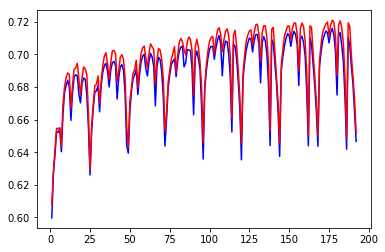

In [40]:
g, ax = plt.subplots(1,1)
ax.plot(r.index, r['KFold score'], color='b')
ax.plot(r.index, r['Hold score'], color='r')

Видим, что KFold (синяя линия) дает более пессимистичную оценку, и это хорошо. KFold делает 5 проверок, 
что лучше, чем одна проверка на отложенной выборке. В дальнейшем анализе будем использовать только KFold валидацию.

Так же мы видим, что точность растет с повышением количества деревьев. Похоже на, что лучшая точность находится
в диапазоне 200-250 деревьев и при дальнейшем увеличении числа деревьев точность не будет расти. 
(Подписи у оси x показывают номер итерации, а не количество деревьев).

На графиках видны резкие провалы и регулярные более мелкие провалы, это значит, что какой-то из параметров настольк 
сильно портит модель, что даже увеличенное количество деревьев не способно это исправить.

Зафиксируем количество деревьев и найдем лучшие оценки для каждого фиксированного варианта количества деревьев.

In [61]:
best = r.groupby('estimators').max()['KFold score']
best

estimators
10     0.687475
20     0.695745
30     0.700592
50     0.705094
100    0.711543
150    0.712245
200    0.714198
250    0.715983
Name: KFold score, dtype: float64

In [62]:
# Теперь мы соединим две таблицы по полю estimators, будет операция аналогичная SQL LEFT JOIN
# Сделаем некоторые технические манипуляции. Возможно, их и не нужно делать, если pandas умеет делать join 
# по float полям. Лень проверять, умеет или нет, просто приведем поля к int.
best=best.reset_index()
best['estimators'] = best['estimators'].astype(int)
r['estimators'] = r['estimators'].astype(int)

In [72]:
#Собственно, сам JOIN
best = pd.merge(r, best, how='left', on='estimators')
best

,estimators,max_depth,learn_rate,KFold score_x,Hold score,time,KFold score_y
0,10,1.0,0.05,0.599661,0.607962,0 days 00:00:07.180010000,0.687475
1,10,1.0,0.10,0.626783,0.627959,0 days 00:00:06.590009000,0.687475
2,10,1.0,0.20,0.638272,0.641854,0 days 00:00:06.610010000,0.687475
3,10,1.0,0.30,0.652657,0.654637,0 days 00:00:06.590009000,0.687475
4,10,1.0,0.50,0.652160,0.654358,0 days 00:00:06.540009000,0.687475
5,10,1.0,1.00,0.654329,0.655055,0 days 00:00:06.590009000,0.687475
6,10,3.0,0.05,0.640324,0.643410,0 days 00:00:20.950030000,0.687475
7,10,3.0,0.10,0.662926,0.668849,0 days 00:00:21.680030000,0.687475
8,10,3.0,0.20,0.676526,0.680052,0 days 00:00:22.310031000,0.687475
9,10,3.0,0.30,0.680924,0.685862,0 days 00:00:21.870031000,0.687475


In [74]:
# Выберем лучшие результаты
best_of_the_best = best[best['KFold score_x']==best['KFold score_y']]
best_of_the_best

,estimators,max_depth,learn_rate,KFold score_x,Hold score,time,KFold score_y
15,10,5.0,0.3,0.687475,0.691683,0 days 00:00:49.120132000,0.687475
39,20,5.0,0.3,0.695745,0.702515,0 days 00:01:36.935544000,0.695745
62,30,5.0,0.2,0.700592,0.706494,0 days 00:02:30.815626000,0.700592
82,50,3.0,0.5,0.705094,0.707738,0 days 00:01:29.519262000,0.705094
105,100,3.0,0.3,0.711543,0.716436,0 days 00:02:53.293911000,0.711543
129,150,3.0,0.3,0.712245,0.718576,0 days 00:05:02.178284000,0.712245
152,200,3.0,0.2,0.714198,0.719223,0 days 00:05:41.593538000,0.714198
176,250,3.0,0.2,0.715983,0.720970,0 days 00:07:46.565686000,0.715983


При конструировании моделей мы использовали max_depth = {1, 3, 5, 7}. Видно, что при малом количестве деревьев лучше работают 
деревья с глубиной 5. Хотя был вариант с глубиной 7, все же оптимальной оказалась глубина 5. С ростом числа деревьев оптимальная
глубина уменьшается и при 250 деревьях оптимальной является глубина 3.

Что же касается learning_rate, то оптимальное значение находится в диапазоне 0,2-0,3. При этом выглядит так, что
при увеличении числа деревьев 0,2 становится более оптимальным. Возможно, на каком-то этапе появится и 0,1.

Нарисуем график лучших результатов при различном числе деревьев.

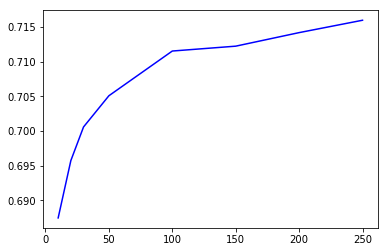

In [76]:
g, ax = plt.subplots(1,1)
ax.plot(best_of_the_best['estimators'], best_of_the_best['KFold score_x'], color='b')

Выглядит так, как будто еще есть потенциал для улучшения модели. 
Может быть 1000 деревьев с learning_rate 0.1 даст самый лучший результат? Возможно.

Исследовать можно бесконечно, но наша цель - сдать зачет и получить сертификат. 
Поэтому тут мы остановимся в исследованиях.

## Определение числа деревьев с помощью метода Early Stopping

Ранее приводилась строчка из документации scikit-learn:
[HTF2009] recommend to set the learning rate to a small constant (e.g. learning_rate <= 0.1) 
and choose n_estimators by early stopping.

Выглядит так, как будто эта рекомендация действительно нам подходит. Попробуем ее использовать. 
Мы используем ту же подвыборку X_test, y_test и ту же KFold валидацию, чтобы результаты были получены в сходных условиях. 
Кроме того, мы используем Stochastic Gradient Boosting, что, согласно теории, даст нам более точную модель и ускорит ее обучение. Так же мы используем warm_start, что позволит при увеличении числа деревьев "наращивать" старую модель, а не создавать ее с нуля. Это ускорит обучение. Мы не будем останавливаться на лучшем результате, как это требует early stopping, а просто обучим несколько лишних моделей.

Если бы это была "боевая" задача, то, конечно, имело бы смысл сделать все более аккуратно и использовать не тестовую 
подвыборку, а полный набор значений, и т.д..

In [80]:
if False:
    clf = GradientBoostingClassifier(learning_rate=0.1,
                                     max_depth=3, 
                                     warm_start=True,
                                     subsample=0.50)
    
    # DataFrame c результатами
    r_2 = DataFrame([])
    # Просто индекс
    i=1
    
    # Если этого не сделать, то будет выводиться ошибка
    X_train = np.ascontiguousarray(X_train.values)
    
    for k in range(250, 1050, 50):
        print('\nStart with {} trees'.format(k))
        clf.n_estimators = k
        
        start_time = datetime.now()
        clf.fit(X_train, y_train)
        end_time = datetime.now()
        
        # Результат на обучаемых данных
        y_pred = clf.predict_proba(X_train)
        score = roc_auc_score(y_train, y_pred[:,1])
        
        # Результат на отложенной выборке
        y_hold_pred = clf.predict_proba(X_hold)
        on_hold_score = roc_auc_score(y_hold, y_hold_pred[:,1])
        
        r_2.loc[i, 'n_estimators'] = k
        r_2.loc[i, 'score'] = score 
        r_2.loc[i, 'Hold score'] = on_hold_score                
        r_2.loc[i, 'time'] = end_time-start_time       
        print(r_2)    
        i += 1
    
    r_2.to_csv('./data/early_stopping_result.csv', index=True, header=True)                
    print('FINISHED!')           
else:
    r_2 = pd.read_csv('./data/early_stopping_result.csv', index_col=0)
    
# Выведем итоговые результаты
print('Final results:\n{}\n'.format(r_2)) 

Final results:
    n_estimators     score  Hold score                       time
1          250.0  0.749587    0.713095  0 days 00:02:18.908114000
2          300.0  0.755107    0.713736  0 days 00:00:32.698870000
3          350.0  0.760248    0.714710  0 days 00:00:31.584807000
4          400.0  0.765024    0.715554  0 days 00:00:30.174726000
5          450.0  0.769932    0.716094  0 days 00:00:30.586749000
6          500.0  0.774311    0.716737  0 days 00:00:30.368737000
7          550.0  0.778452    0.716963  0 days 00:00:31.690812000
8          600.0  0.782271    0.717178  0 days 00:00:34.992002000
9          650.0  0.786215    0.717442  0 days 00:00:31.380795000
10         700.0  0.789981    0.717426  0 days 00:00:29.568691000
11         750.0  0.793526    0.717678  0 days 00:00:29.114665000
12         800.0  0.796875    0.717640  0 days 00:00:28.732643000
13         850.0  0.800190    0.717249  0 days 00:00:29.198670000
14         900.0  0.803545    0.717258  0 days 00:00:29.19067

Видим, что warm_start работает - первая модель тренировалась 2 минуты. Каждая следующая модель тренируется около 30 сек.

Так же видим, что модели переобучаются начиная с некоторого числа деревьев. Нарисуем графики.

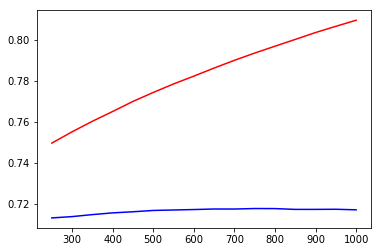

In [82]:
g, ax = plt.subplots(1,1)
ax.plot(r_2['n_estimators'], r_2['score'], color='r')
ax.plot(r_2['n_estimators'], r_2['Hold score'], color='b')

Синяя кривая - оценка на валидации. Получим лучшее значение числа деревьев.

In [83]:
r_2[r_2['Hold score']==r_2['Hold score'].max()]

,n_estimators,score,Hold score,time
11,750.0,0.793526,0.717678,0 days 00:00:29.114665000


Вывод:

Ранее была получена модель (n_estimators=250, max_depth=3, learning_rate=0.2), которая давала точность на отложенной выборке = 0.720970.

Точность последней модели (n_estimators=750, max_depth=3, learning_rate=0.1) = 0.717678

Выглядит так, что имеет смысл продолжать первый подход, увеличивая там количество деревьев. Тем не менее, тут мы оставновимся.

Обучим лучшие модели на полных данных и загрузим их на kaggle.

In [96]:
X = data[original_columns]

# Модель 1
clf_1 = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, max_depth=3)

clf_1.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=250, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [97]:
y_train_pred = clf_1.predict_proba(X)
train_score = roc_auc_score(y, y_train_pred[:,1])
train_score

0.76166551395321647

In [98]:
y_result = clf_1.predict_proba(test[original_columns])[:,1]
# Сохраним данные в формате kaggle
predicted = DataFrame([])
predicted['radiant_win'] = y_result
predicted['match_id'] = test.index
predicted = predicted.set_index('match_id')
predicted.to_csv('./data/submission_1.csv', index=True, header=True)

Обучим вторую модель

In [99]:
# Модель 2
clf_2 = GradientBoostingClassifier(n_estimators=750, learning_rate=0.1, max_depth=3)

clf_2.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=750, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [100]:
y_train_pred = clf_2.predict_proba(X)
train_score = roc_auc_score(y, y_train_pred[:,1])
train_score

0.77763169487064054

In [101]:
y_result = clf_2.predict_proba(test[original_columns])[:,1]
# Сохраним данные в формате kaggle
predicted = DataFrame([])
predicted['radiant_win'] = y_result
predicted['match_id'] = test.index
predicted = predicted.set_index('match_id')
predicted.to_csv('./data/submission_2.csv', index=True, header=True)

Результаты на kaggle:

Модель 1: 0.72726 (место 742 из 813)

Модель 2: 0.73150 (место 736 из 813)

Вот такой сюрприз.

Очень высокая вероятность того, что если увеличить количество деревьев в первом подходе, результат будет лучше. Но с другой стороны очевидно, что борьба будет за доли процентов и без feature ingeneering не обойтись.

## Предсказание победителя методом логистической регрессии

Часть кода повторяется, так как изначально это было 2 отдельных блокнота, но coursera позволяет загрузить лишь один блокнот. Поэтому был копи-паст.

In [103]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import re
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 50

In [104]:
# Загрузим данные
data = pd.read_csv('./data/features.csv', index_col='match_id')
test = pd.read_csv('./data/features_test.csv', index_col='match_id')

# Удалим столбцы из будущего и время начала матча
data = data.drop(['start_time','duration',
                  'tower_status_radiant', 'tower_status_dire', 
                  'barracks_status_radiant', 'barracks_status_dire'], axis=1)
test = test.drop(['start_time'], axis=1)

# По инструкции - заполним все NaN на 0
data = data.fillna(0)
test = test.fillna(0)

# Отделим от тестового набора верные ответы
y = data.pop('radiant_win')

# Нормализуем все переменные
scaler = StandardScaler()
# Преобразуем обучающую выборку
X = scaler.fit_transform(data)
# Аналогично преобразуем тестовую выборку
X_test = scaler.transform(test)

In [105]:
# Далее проведем подбор параметра C. Поскольку код выполняется достаточно долго,
# то мы сделаем это лишь один раз и сохраним результаты в файл.
# Если нам в следующий раз потребуются результаты, то нет необходимости делать
# вычисления снова - мы просто загрузим данные из файла.
# Чтобы снова проделать вычисления - после if нужно поставить True
if False:
    # Разобьем выборку на обучающую и тестовую (30%). 
    # Это не является необходимым, просто для интереса.
    X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.3)
    
    # Помимо валидации на отложенной выборке будем делать KFold, как и требуется по условию
    cv = KFold(n_splits=5, shuffle=True)
    
    # i - обычный счетчик, r - DataFrame, куда мы будем записывать значения на итерациях
    i = 1
    r = DataFrame([])      
    
    # Сделаем список возможных С
    C_list = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    # combs_cnt - количество вариантов параметров
    combs_cnt = len(C_list) 

    # По всем вариантам C строим классификатор и смотрим score    
    for C in C_list:
        clf = LogisticRegression(C=C, max_iter=2000, penalty='l2', tol=0.00001)
        
        start_time = datetime.now()
        # cross_val_score возвращает несколько значений, сразу возьмем среднее
        score = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=cv, scoring='roc_auc').mean()
        end_time = datetime.now()
        
        # Поскольку мы делаем еще и валидацию на отложенной выборке, то 
        # обучим модель на тренировочном кусочке, сделаем прогноз для отложенной выборки
        # и посчитаем score
        clf = LogisticRegression(C=C, max_iter=2000, penalty='l2', tol=0.00001)
        clf.fit(X_train, y_train)
        y_hold_pred = clf.predict_proba(X_hold)
        on_hold_score = roc_auc_score(y_hold, y_hold_pred[:,1])
        
        # Запишем результаты итерации в DataFrame r
        r.loc[i, 'C'] = C
        r.loc[i, 'KFold score'] = score                
        r.loc[i, 'Hold score'] = on_hold_score
        r.loc[i, 'time'] = end_time-start_time
             
        # Распечатаем промежуточный результат шага, чтобы видеть прогресс
        print('Step {}/{}:\n{}\n'.format(i, combs_cnt, r))
        i += 1
    # Сохраним результаты в файл, чтобы не пришлось делать вычисления снова        
    r.to_csv('./data/logit_result_3.csv', index=True, header=True)        
    print('FINISHED!\n')  
else:
    # Этот блок выполняется, если мы не хотим снова делать расчеты, а хотим использовать сохраненные ранее
    r = pd.read_csv('./data/logit_result_3.csv', index_col=0)
    
# Выведем таблицу с результатами
print('Final results:\n{}\n'.format(r))
print('Best KFold score:\n{}\n'.format(r[r['KFold score']==r['KFold score'].max()]))
print('Best Hold score:\n{}\n'.format(r[r['Hold score']==r['Hold score'].max()]))  

Final results:
          C  KFold score  Hold score                       time
1     0.001     0.717395    0.711821  0 days 00:00:09.898567000
2     0.010     0.717417    0.711978  0 days 00:00:14.587834000
3     0.100     0.717712    0.711921  0 days 00:00:15.635894000
4     1.000     0.717796    0.711914  0 days 00:00:16.013916000
5    10.000     0.717785    0.711913  0 days 00:00:16.135923000
6   100.000     0.717696    0.711913  0 days 00:00:15.982915000
7  1000.000     0.717704    0.711913  0 days 00:00:15.904910000

Best KFold score:
     C  KFold score  Hold score                       time
4  1.0     0.717796    0.711914  0 days 00:00:16.013916000

Best Hold score:
      C  KFold score  Hold score                       time
2  0.01     0.717417    0.711978  0 days 00:00:14.587834000



Нарисуем график

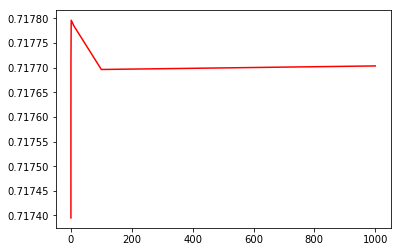

In [106]:
g, ax = plt.subplots(1,1)
ax.plot(r['C'], r['KFold score'], color='r')
#ax.plot(r['C'], r['Hold score'], color='b')

Как ни крути, но результат практически на зависит от C. Наверное, имеет смысл поставить C=1.0.

## Построение модели после удаления категориальных признаков

In [121]:
# Сохраним на будущее старый набор полей
original_columns = data.columns
original_columns

Index(['lobby_type', 'r1_hero', 'r1_level', 'r1_xp', 'r1_gold', 'r1_lh', 'r1_kills', 'r1_deaths',
       'r1_items', 'r2_hero',
       ...
       'h_100', 'h_101', 'h_102', 'h_103', 'h_104', 'h_105', 'h_106', 'h_109', 'h_110', 'h_112'],
      dtype='object', length=209)

In [122]:
# Создадим группы колонок с Героями, чтобы потом их можно было легко использовать в будущем
r_heroes_cols = ['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero']
d_heroes_cols = ['d1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

# Колонки с героями обеих команд
heroes_cols = r_heroes_cols + d_heroes_cols

In [123]:
columns_wo_categorial = [x for x in original_columns if x not in heroes_cols] #list() - ['lobby_type'] - list(heroes_cols)
columns_wo_categorial.remove('lobby_type') 

In [125]:
# Далее проведем подбор параметра C. Поскольку код выполняется достаточно долго,
# то мы сделаем это лишь один раз и сохраним результаты в файл.
# Если нам в следующий раз потребуются результаты, то нет необходимости делать
# вычисления снова - мы просто загрузим данные из файла.
# Чтобы снова проделать вычисления - после if нужно поставить True
X = data[columns_wo_categorial]

if False:
    # Разобьем выборку на обучающую и тестовую (30%). 
    # Это не является необходимым, просто для интереса.
    X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.3)
    
    # Помимо валидации на отложенной выборке будем делать KFold, как и требуется по условию
    cv = KFold(n_splits=5, shuffle=True)
    
    # i - обычный счетчик, r - DataFrame, куда мы будем записывать значения на итерациях
    i = 1
    r = DataFrame([])      
    
    # Сделаем список возможных С
    C_list = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    # combs_cnt - количество вариантов параметров
    combs_cnt = len(C_list) 

    # По всем вариантам C строим классификатор и смотрим score    
    for C in C_list:
        clf = LogisticRegression(C=C, max_iter=2000, penalty='l2', tol=0.00001)
        
        start_time = datetime.now()
        # cross_val_score возвращает несколько значений, сразу возьмем среднее
        score = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=cv, scoring='roc_auc').mean()
        end_time = datetime.now()
        
        # Поскольку мы делаем еще и валидацию на отложенной выборке, то 
        # обучим модель на тренировочном кусочке, сделаем прогноз для отложенной выборки
        # и посчитаем score
        clf = LogisticRegression(C=C, max_iter=2000, penalty='l2', tol=0.00001)
        clf.fit(X_train, y_train)
        y_hold_pred = clf.predict_proba(X_hold)
        on_hold_score = roc_auc_score(y_hold, y_hold_pred[:,1])
        
        # Запишем результаты итерации в DataFrame r
        r.loc[i, 'C'] = C
        r.loc[i, 'KFold score'] = score                
        r.loc[i, 'Hold score'] = on_hold_score
        r.loc[i, 'time'] = end_time-start_time
             
        # Распечатаем промежуточный результат шага, чтобы видеть прогресс
        print('Step {}/{}:\n{}\n'.format(i, combs_cnt, r))
        i += 1
    # Сохраним результаты в файл, чтобы не пришлось делать вычисления снова        
    r.to_csv('./data/logit_result_4.csv', index=True, header=True)        
    print('FINISHED!\n')  
else:
    # Этот блок выполняется, если мы не хотим снова делать расчеты, а хотим использовать сохраненные ранее
    r = pd.read_csv('./data/logit_result_4.csv', index_col=0)
    
# Выведем таблицу с результатами
print('Final results:\n{}\n'.format(r))
print('Best KFold score:\n{}\n'.format(r[r['KFold score']==r['KFold score'].max()]))
print('Best Hold score:\n{}\n'.format(r[r['Hold score']==r['Hold score'].max()]))  

Final results:
          C  KFold score  Hold score                       time
1     0.001     0.743119    0.745316  0 days 00:03:19.101388000
2     0.010     0.750635    0.751204  0 days 00:04:58.436070000
3     0.100     0.750902    0.751417  0 days 00:06:27.208148000
4     1.000     0.751146    0.751369  0 days 00:06:26.733119000
5    10.000     0.750808    0.751363  0 days 00:06:50.676490000
6   100.000     0.750859    0.751390  0 days 00:06:13.154343000
7  1000.000     0.751174    0.751376  0 days 00:07:37.945193000

Best KFold score:
        C  KFold score  Hold score                       time
7  1000.0     0.751174    0.751376  0 days 00:07:37.945193000

Best Hold score:
     C  KFold score  Hold score                       time
3  0.1     0.750902    0.751417  0 days 00:06:27.208148000



Вывод: оставляем C=0.1

## Теперь попробуем с мешком героев

Index(['lobby_type', 'r1_hero', 'r1_level', 'r1_xp', 'r1_gold', 'r1_lh', 'r1_kills', 'r1_deaths',
       'r1_items', 'r2_hero',
       ...
       'radiant_ward_sentry_count', 'radiant_first_ward_time', 'dire_bottle_time',
       'dire_courier_time', 'dire_flying_courier_time', 'dire_tpscroll_count', 'dire_boots_count',
       'dire_ward_observer_count', 'dire_ward_sentry_count', 'dire_first_ward_time'],
      dtype='object', length=101)

In [108]:
# Объединим все колонки с героями из тренировочных данных и из тестовых данных
# Хотя маловероятно, что в тестовых данных есть герои, которые не использовались
# в тренировочных, но все же сделаем это
heroes = data[heroes_cols].append(test[heroes_cols])
# Получим массив с уникальными id героев
unique_heroes = np.unique(heroes.values)
# Количество героев - это размерность массива
print('Number of unique heroes: {}\n'.format(unique_heroes.shape[0]))

Number of unique heroes: 108



In [109]:
# Сформируем мешок из героев
for i in unique_heroes:
    # Сформируем название поля вида h_1, h_2 и т.д.
    h_name = 'h_'+str(i)
    # Выведем поле для оценки прогресса
    # print(h_name)
    # По всем столбцам с героями команды сделаем сравнение значения с id героя
    # Если номер героя совпадет, то в результате будет True, иначе False
    # Сделав сумму по всем таким полям каждой строчки мы получим 1, если
    # есть True, или 0, если нет True
    # Поскольку за игру герой может использоваться лишь 1 раз, то возможные значения {0, 1}
    
    # r - это столбец с 0 или 1 для данного героя в команде Radiant
    r = (data[r_heroes_cols]==i).sum(axis=1)
    # d - это аналогичный столбец с 0 или 1 для данного героя в команде Dire
    d = (data[d_heroes_cols]==i).sum(axis=1)
    # Разница между столбцами даст другой столбец с {-1,0,1}
    # Этот столбец мы тут же добавляем в DataFrame data 
    data[h_name] = r - d
    
    # Аналогично сделаем для тестовой выборки
    r = (test[r_heroes_cols]==i).sum(axis=1)
    d = (test[d_heroes_cols]==i).sum(axis=1)
    test[h_name] = r - d    

bag_of_heroes_columns = [x for x in original_columns if x not in heroes_cols] #list() - ['lobby_type'] - list(heroes_cols)
bag_of_heroes_columns.remove('lobby_type') 
#bag_of_heroes_columns

# Удалим лобби и героев, так как они больше не нужны
#data = data.drop(['lobby_type'] + heroes_cols, axis=1)                      
#test = test.drop(['lobby_type'] + heroes_cols, axis=1) 

In [110]:
# Тут мы тупо скопируем код, который был выше. Можно сделать процедуру, но лень.
# Никаких отличий в коде нет
# Есть лишь отличие в данных, тут добавились поля с героями

# Нормализуем все переменные
scaler = StandardScaler()
# Преобразуем обучающую выборку
X = scaler.fit_transform(data[bag_of_heroes_columns])
# Аналогично преобразуем тестовую выборку
X_test = scaler.transform(test[bag_of_heroes_columns])

# Про включение-выключение расчетов - см. аналогичный блок выше
if False:
    # Разобьем выборку на обучающую и тестовую (30%). 
    # Это не является необходимым, просто для интереса.
    X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.3)
    
    # Помимо валидации на отложенной выборке будем делать KFold, как и требуется по условию
    cv = KFold(n_splits=5, shuffle=True)
    
    # i - обычный счетчик, r - DataFrame, куда мы будем записывать значения на итерациях
    i = 1
    r = DataFrame([])      
    
    # Сделаем список возможных С
    C_list = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    # combs_cnt - количество вариантов параметров
    combs_cnt = len(C_list) 

    # По всем вариантам C строим классификатор и смотрим score    
    for C in C_list:
        clf = LogisticRegression(C=C, max_iter=2000, penalty='l2', tol=0.00001)
        
        start_time = datetime.now()
        # cross_val_score возвращает несколько значений, сразу возьмем среднее
        score = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=cv, scoring='roc_auc').mean()
        end_time = datetime.now()
        
        # Поскольку мы делаем еще и валидацию на отложенной выборке, то 
        # обучим модель на тренировочном кусочке, сделаем прогноз для отложенной выборки
        # и посчитаем score
        clf = LogisticRegression(C=C, max_iter=2000, penalty='l2', tol=0.00001)
        clf.fit(X_train, y_train)
        y_hold_pred = clf.predict_proba(X_hold)
        on_hold_score = roc_auc_score(y_hold, y_hold_pred[:,1])
        
        # Запишем результаты итерации в DataFrame r
        r.loc[i, 'C'] = C
        r.loc[i, 'KFold score'] = score                
        r.loc[i, 'Hold score'] = on_hold_score
        r.loc[i, 'time'] = end_time-start_time
             
        # Распечатаем промежуточный результат шага, чтобы видеть прогресс
        print('Step {}/{}:\n{}\n'.format(i, combs_cnt, r))
        i += 1
    # Сохраним результаты в файл, чтобы не пришлось делать вычисления снова        
    r.to_csv('./data/logit_result_heroes.csv', index=True, header=True)        
    print('FINISHED!\n')  
else:
    # Этот блок выполняется, если мы не хотим снова делать расчеты, а хотим использовать сохраненные ранее
    r = pd.read_csv('./data/logit_result_heroes.csv', index_col=0)
    
# Выведем таблицу с результатами
print('Final results:\n{}\n'.format(r))
print('Best KFold score:\n{}\n'.format(r[r['KFold score']==r['KFold score'].max()]))
print('Best Hold score:\n{}\n'.format(r[r['Hold score']==r['Hold score'].max()])) 

Final results:
          C  KFold score  Hold score                       time
1     0.001     0.750663    0.749952  0 days 00:00:18.473057000
2     0.010     0.751583    0.750714  0 days 00:00:26.353507000
3     0.100     0.751545    0.750730  0 days 00:00:28.378623000
4     1.000     0.751535    0.750731  0 days 00:00:29.962713000
5    10.000     0.751264    0.750731  0 days 00:00:30.097722000
6   100.000     0.751296    0.750731  0 days 00:00:28.754645000
7  1000.000     0.751103    0.750731  0 days 00:00:28.817648000

Best KFold score:
      C  KFold score  Hold score                       time
2  0.01     0.751583    0.750714  0 days 00:00:26.353507000

Best Hold score:
        C  KFold score  Hold score                       time
7  1000.0     0.751103    0.750731  0 days 00:00:28.817648000



Картинка та же, результат не зависит от C. Возьмем С=1.0

Однако точность улучшилась. Без мешка героев точность была 0.717796, с мешком 0.751535

## Публикация данных на kaggle

Обучим модель на исходных данных

In [111]:
X = data[original_columns]

# Модель 1
clf_1 = LogisticRegression(C=0.1, max_iter=2000, penalty='l2', tol=0.00001)

clf_1.fit(X, y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-05,
          verbose=0, warm_start=False)

In [112]:
y_train_pred = clf_1.predict_proba(X)
train_score = roc_auc_score(y, y_train_pred[:,1])
train_score

0.71786583422142314

In [113]:
y_result = clf_1.predict_proba(test[original_columns])[:,1]
# Сохраним данные в формате kaggle
predicted = DataFrame([])
predicted['radiant_win'] = y_result
predicted['match_id'] = test.index
predicted = predicted.set_index('match_id')
predicted.to_csv('./data/submission_3.csv', index=True, header=True)

Обучим модель с мешком героев

In [114]:
X = data[bag_of_heroes_columns]

# Модель 1
clf_2 = LogisticRegression(C=0.1, max_iter=2000, penalty='l2', tol=0.00001)

clf_2.fit(X, y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-05,
          verbose=0, warm_start=False)

In [115]:
y_train_pred = clf_2.predict_proba(X)
train_score = roc_auc_score(y, y_train_pred[:,1])
train_score

0.75428895557836473

In [116]:
y_result = clf_2.predict_proba(test[bag_of_heroes_columns])[:,1]
# Сохраним данные в формате kaggle
predicted = DataFrame([])
predicted['radiant_win'] = y_result
predicted['match_id'] = test.index
predicted = predicted.set_index('match_id')
predicted.to_csv('./data/submission_4.csv', index=True, header=True)

Результаты на kaggle:

Модель 1: 0.72267 (место 757 из 813)

Модель 2: 0.75489 (место 624 из 813)